# Super resolution x4

In [1]:
import os
import os.path as osp
import glob
import json

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

import ESRGAN.RRDBNet_arch as arch

#### [MODEL download](https://drive.google.com/drive/u/0/folders/17VYV_SoZZesU6mbxz2dMAIccSSlqLecY)
#### [Github](https://github.com/xinntao/ESRGAN)

In [2]:
# 모델 로드
model_path = 'ESRGAN/RRDB_ESRGAN_x4.pth' 
device = torch.device('cuda')

model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

print('Model path {:s}. \nTesting...'.format(model_path))

Model path ESRGAN/RRDB_ESRGAN_x4.pth. 
Testing...


In [3]:
train_img_folder = glob.glob('data/*_receipt/img/train/*')
train_ufo = glob.glob('data/*_receipt/ufo/train.json')

# Super resolution을 위한 디렉토리 생성
for i in ["japanese", "vietnamese", "chinese", "thai"]:
    os.makedirs(f'super_resolution/{i}_receipt/img/train', exist_ok=True)
    os.makedirs(f'super_resolution/{i}_receipt/img/test', exist_ok=True)
    os.makedirs(f'super_resolution/{i}_receipt/ufo', exist_ok=True)

In [4]:
# 주석 파일을 하나로 합치기
total_anno = dict()
for ufo_path, language in zip(train_ufo, ["japanese", "vietnamese", "chinese", "thai"]):
    with open(ufo_path, 'r', encoding='utf-8') as f:
        anno = json.load(f)
    total_anno[language] = anno

In [5]:
def super_resolution_tile(img_tile):
    """ 이미지 타일에 Super Resolution을 적용하고 결과 반환 """
    img_tile = img_tile * 1.0 / 255
    img_tile = torch.from_numpy(np.transpose(img_tile[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img_tile.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output_tile = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output_tile = np.transpose(output_tile[[2, 1, 0], :, :], (1, 2, 0))
    output_tile = (output_tile * 255.0).round().astype(np.uint8)
    
    # 메모리 해제
    del img_LR
    torch.cuda.empty_cache()
    
    return output_tile

## Train data super resolution

In [6]:
# 각 언어별로 이미지 처리 및 좌표 스케일링
for path in train_img_folder:
    base = osp.splitext(osp.basename(path))[0]
    
    # 언어에 따라 저장 경로 설정
    if "chinese" in path:
        save_path = f"super_resolution/chinese_receipt/img/train/{base}_super_resolution.jpg"
    elif "japanese" in path:
        save_path = f"super_resolution/japanese_receipt/img/train/{base}_super_resolution.jpg"
    elif "thai" in path:
        save_path = f"super_resolution/thai_receipt/img/train/{base}_super_resolution.jpg"
    elif "vietnamese" in path:
        save_path = f"super_resolution/vietnamese_receipt/img/train/{base}_super_resolution.jpg"
    
    print(save_path)

    # 이미지 로드 및 크기 가져오기
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = img.shape
    h_quarter, w_quarter = h // 4, w // 4

    # 이미지 16개 타일로 나누기
    tiles = [
        img[i*h_quarter:(i+1)*h_quarter, j*w_quarter:(j+1)*w_quarter]
        for i in range(4) for j in range(4)
    ]
    
    # 각 타일에 Super Resolution 적용
    output_tiles = [super_resolution_tile(tile) for tile in tiles]
    
    # 16개의 타일을 다시 합치기
    rows = [np.hstack(output_tiles[i*4:(i+1)*4]) for i in range(4)]
    output_img = np.vstack(rows)

    # 결과 저장
    cv2.imwrite(save_path, output_img)

    # 메모리 해제
    del img, output_img, output_tiles
    torch.cuda.empty_cache()

super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000812_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000264_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000760_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000704_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000126_page0001_super_resolution.jpg


In [7]:
# 4배 확대 설정
scale_factor = 4
total_anno = dict()

# 각 언어의 주석 파일 로드
for ufg_path, language in zip(train_ufo, ["japanese", "vietnamese", "chinese", "thai"]):
    with open(ufg_path, 'r', encoding='utf-8') as f:
        anno = json.load(f)
    total_anno[language] = anno

# 주석 파일의 points 좌표를 4배 확대하고 파일 이름에 _super_resolution 접미사 추가
for language in ["japanese", "vietnamese", "chinese", "thai"]:
    updated_images = {}  # 업데이트된 이미지 정보를 저장할 딕셔너리
    
    for img_data, img_info in total_anno[language]["images"].items():
        # 파일 이름에 '_super_resolution' 접미사 추가
        new_img_name = osp.splitext(img_data)[0] + "_super_resolution.jpg"
        
        # 기존 이미지 정보 복사하고, points 좌표 4배 확대
        updated_img_info = img_info.copy()
        updated_img_info['img_w'] = updated_img_info['img_w'] * scale_factor
        updated_img_info['img_h'] = updated_img_info['img_h'] * scale_factor
        
        for word_id, word_data in updated_img_info["words"].items():
            if not word_data.get("scaled", False):
                word_data['points'] = [[x * scale_factor, y * scale_factor] for x, y in word_data['points']]
                word_data["scaled"] = True  # 확대 여부 표시하여 재확대 방지
        
        # 새 이미지 이름으로 변경된 데이터를 저장
        updated_images[new_img_name] = updated_img_info
    
    # 업데이트된 이미지 정보를 기존 데이터에 덮어쓰기
    total_anno[language]["images"] = updated_images

# 변경된 주석 파일 저장
for language in ["japanese", "vietnamese", "chinese", "thai"]:
    ufo_save_path = f'super_resolution/{language}_receipt/ufo/train.json'
    with open(ufo_save_path, 'w', encoding='utf-8') as f:
        json.dump(total_anno[language], f, ensure_ascii=False, indent=4)

#### train image bbox visualization

이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000911_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000028_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000685_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000196_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000135_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000134_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000132_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/e

[ WARN:0@200.331] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000911_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@200.332] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000028_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@200.332] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000685_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@200.332] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000196_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@200.332] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/jap

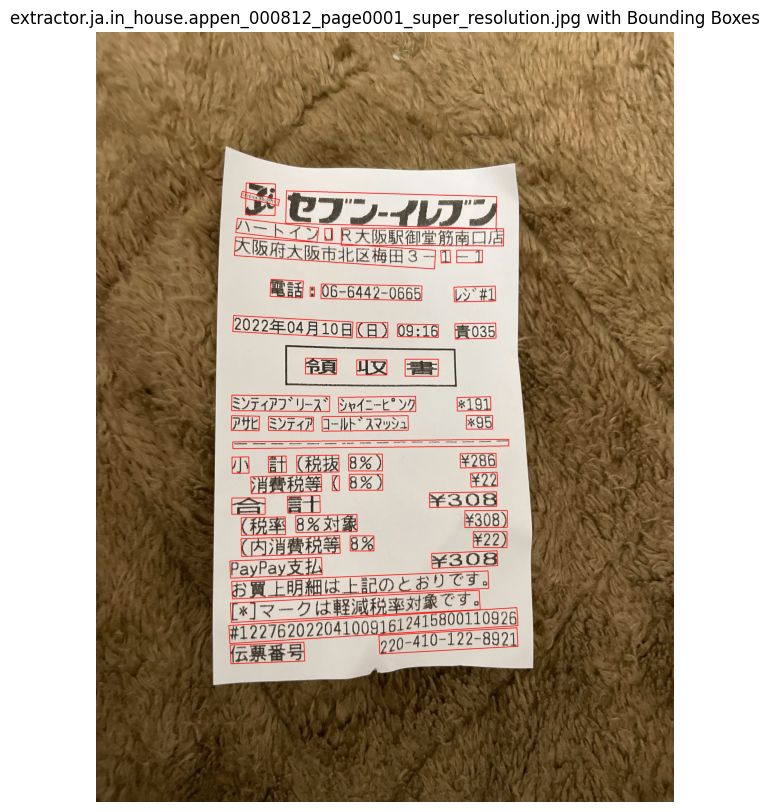

이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000894_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000351_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000644_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000844_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000993_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000853_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000983_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/e

[ WARN:0@203.028] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000894_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@203.029] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000351_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@203.029] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000644_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@203.029] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000844_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@203.029] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/jap

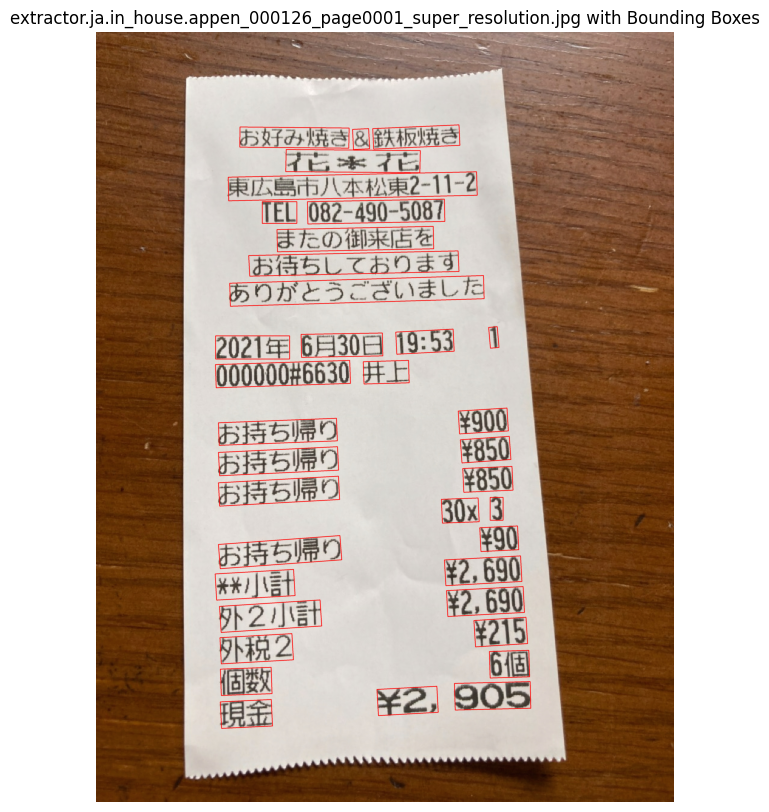

이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_001018_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000253_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000044_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000720_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000927_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000942_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000317_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/e

[ WARN:0@205.717] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_001018_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@205.717] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000253_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@205.718] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000044_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@205.718] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000720_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@205.718] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/jap

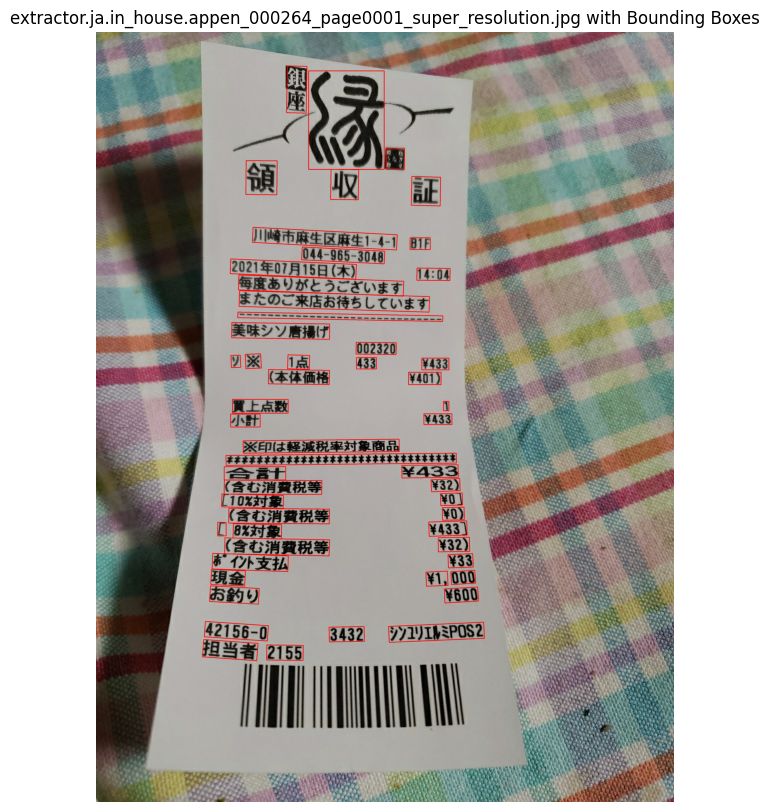

이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000561_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000464_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000375_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000857_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000075_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000309_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000884_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/e

[ WARN:0@208.546] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000561_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@208.546] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000464_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@208.546] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000375_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@208.546] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000857_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@208.547] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/jap

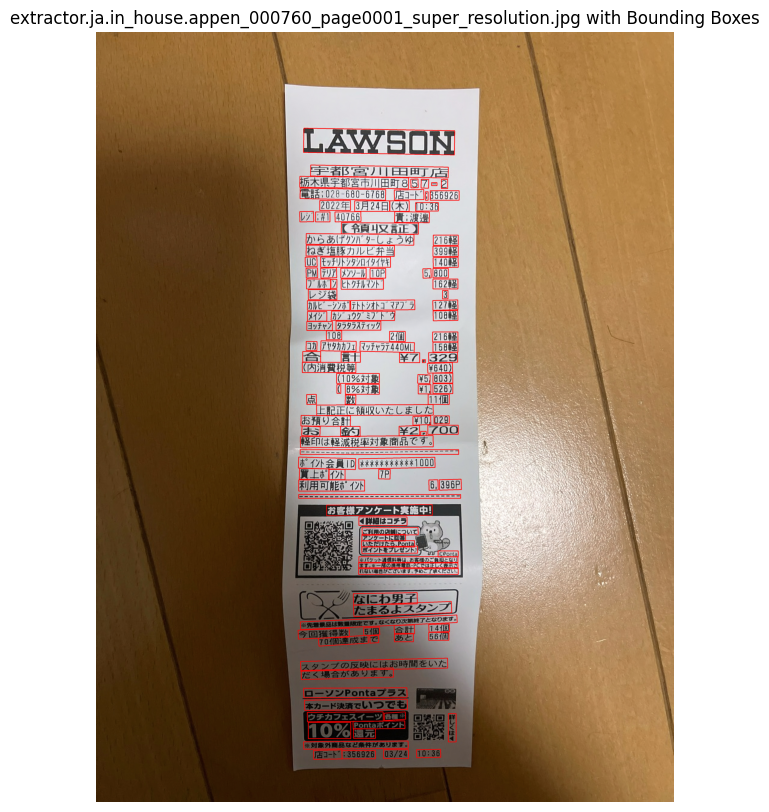

[ WARN:0@211.360] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000084_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity


이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000084_page0001_super_resolution.jpg


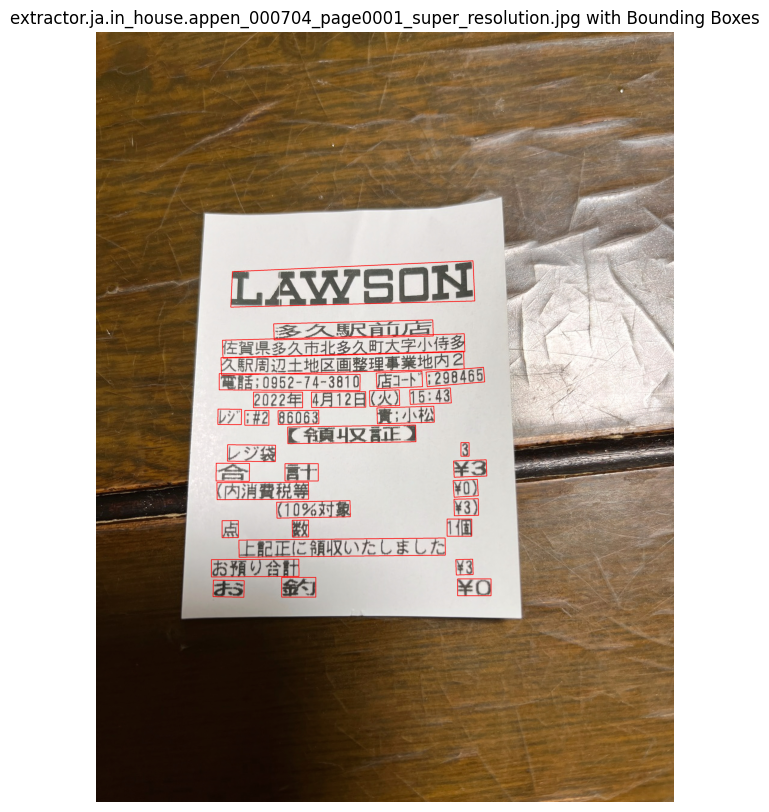

이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000105_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000645_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000738_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000226_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000677_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000577_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000632_page0001_super_resolution.jpg
이미지 파일을 찾을 수 없습니다: super_resolution_temp/japanese_receipt/img/train/e

[ WARN:0@214.156] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000105_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@214.157] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000645_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@214.157] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000738_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@214.157] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/japanese_receipt/img/train/extractor.ja.in_house.appen_000226_page0001_super_resolution.jpg'): can't open/read file: check file path/integrity
[ WARN:0@214.157] global loadsave.cpp:241 findDecoder imread_('super_resolution_temp/jap

In [8]:
# 이미지와 주석 파일 경로
languages = ["japanese", "vietnamese", "chinese", "thai"]

for language in languages:
    # 주석 파일 경로
    ufo_path = f'super_resolution/{language}_receipt/ufo/train.json'
    with open(ufo_path, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    
    # 이미지 경로 폴더
    img_folder = f'super_resolution/{language}_receipt/img/train/'
    idx = 0
    for img_name, img_data in annotations["images"].items():
        idx += 1
        # 이미지 파일 경로 설정
        img_path = osp.join(img_folder, img_name)
        
        # 이미지 로드
        img = cv2.imread(img_path)
        if img is None:
            print(f"이미지 파일을 찾을 수 없습니다: {img_path}")
            continue

        # 각 단어의 Bounding Box 그리기
        for word_id, word_data in img_data["words"].items():
            points = word_data["points"]
            # points를 정수로 변환
            points = np.array(points, dtype=np.int32)

            # Bounding Box 그리기
            cv2.polylines(img, [points], isClosed=True, color=(0, 0, 255), thickness=3)

        # BGR을 RGB로 변환하여 matplotlib으로 표시
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 결과 이미지 주피터 노트북에 시각화
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"{img_name} with Bounding Boxes")
        plt.show()

        # 하나의 이미지에 대해서만 확인하려면 여기서 break 추가
        if idx == 5:
            break
    # 언어별로 하나의 이미지만 확인하고 싶으면 여기서 break 추가
    break

### Test data super resolution

In [9]:
test_img_folder = glob.glob('data/*_receipt/img/test/*')
test_ufo = glob.glob('data/*_receipt/ufo/test.json')

In [10]:
# 각 언어별로 이미지 처리 및 좌표 스케일링
for path in test_img_folder:
    base = osp.splitext(osp.basename(path))[0]
    
    # 언어에 따라 저장 경로 설정
    if "chinese" in path:
        save_path = f"super_resolution/chinese_receipt/img/test/{base}_super_resolution.jpg"
    elif "japanese" in path:
        save_path = f"super_resolution/japanese_receipt/img/test/{base}_super_resolution.jpg"
    elif "thai" in path:
        save_path = f"super_resolution/thai_receipt/img/test/{base}_super_resolution.jpg"
    elif "vietnamese" in path:
        save_path = f"super_resolution/vietnamese_receipt/img/test/{base}_super_resolution.jpg"
    
    print(save_path)

    # 이미지 로드 및 크기 가져오기
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = img.shape
    h_quarter, w_quarter = h // 4, w // 4

    # 이미지 16개 타일로 나누기
    tiles = [
        img[i*h_quarter:(i+1)*h_quarter, j*w_quarter:(j+1)*w_quarter]
        for i in range(4) for j in range(4)
    ]
    
    # 각 타일에 Super Resolution 적용
    output_tiles = [super_resolution_tile(tile) for tile in tiles]
    
    # 16개의 타일을 다시 합치기
    rows = [np.hstack(output_tiles[i*4:(i+1)*4]) for i in range(4)]
    output_img = np.vstack(rows)

    # 결과 저장
    cv2.imwrite(save_path, output_img)

    # 메모리 해제
    del img, output_img, output_tiles
    torch.cuda.empty_cache()

super_resolution_temp/japanese_receipt/img/test/extractor.ja.in_house.appen_000495_page0001_super_resolution.jpg


super_resolution_temp/japanese_receipt/img/test/extractor.ja.in_house.appen_000280_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/test/extractor.ja.in_house.appen_000722_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/test/extractor.ja.in_house.appen_000410_page0001_super_resolution.jpg
super_resolution_temp/japanese_receipt/img/test/extractor.ja.in_house.appen_000654_page0001_super_resolution.jpg


In [11]:
# 4배 확대 설정
scale_factor = 4
total_anno = dict()

# 각 언어의 주석 파일 로드
for ufg_path, language in zip(test_ufo, ["japanese", "vietnamese", "chinese", "thai"]):
    with open(ufg_path, 'r', encoding='utf-8') as f:
        anno = json.load(f)
    total_anno[language] = anno

# 주석 파일의 points 좌표를 4배 확대하고 파일 이름에 _super_resolution 접미사 추가
for language in ["japanese", "vietnamese", "chinese", "thai"]:
    updated_images = {}  # 업데이트된 이미지 정보를 저장할 딕셔너리
    
    for img_data, img_info in total_anno[language]["images"].items():
        # 파일 이름에 '_super_resolution' 접미사 추가
        new_img_name = osp.splitext(img_data)[0] + "_super_resolution.jpg"

        # 기존 이미지 정보 복사하고, points 좌표 4배 확대
        updated_img_info = img_info.copy()
        updated_img_info['img_w'] = updated_img_info['img_w'] * scale_factor
        updated_img_info['img_h'] = updated_img_info['img_h'] * scale_factor
        
        # 새 이미지 이름으로 변경된 데이터를 저장
        updated_images[new_img_name] = updated_img_info
    
    # 업데이트된 이미지 정보를 기존 데이터에 덮어쓰기
    total_anno[language]["images"] = updated_images

# 변경된 주석 파일 저장
for language in ["japanese", "vietnamese", "chinese", "thai"]:
    ufo_save_path = f'super_resolution/{language}_receipt/ufo/test.json'
    with open(ufo_save_path, 'w', encoding='utf-8') as f:
        json.dump(total_anno[language], f, ensure_ascii=False, indent=4)